## Helper functions & Example experiment

In [3]:
"""Imports"""
from langchain.chat_models import ChatOpenAI
from langchain.prompts.chat import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    AIMessagePromptTemplate,
    HumanMessagePromptTemplate,
)
from langchain.schema import (
    AIMessage,
    HumanMessage,
    SystemMessage
)

from cot import Collection
import yaml

In [4]:
# Helper functions to call OpenAI model, system also generates reasoning
def system_experiment(data,model, path_system_template):
    chat = ChatOpenAI(
        temperature=0,
        model_name=model,
        request_timeout=600,
        max_retries=1,
    )

    human_template="""Answer the question:{question}\nwith the following answer options:{answer_options}"""
    human_message_prompt = HumanMessagePromptTemplate.from_template(human_template)
    
    with open(path_system_template, 'r') as file:
        template = file.read()
    system_message_prompt = SystemMessagePromptTemplate.from_template(template)
    
    chat_prompt = ChatPromptTemplate.from_messages([system_message_prompt, human_message_prompt])  
    input_dict = {'chat':chat,'chat_prompt':chat_prompt} 
    
    return data.system_generate(input_dict)

def save_as_yaml(data, filepath):
    with open(filepath, 'w') as file:
        yaml.dump(data, file)

In [6]:
import pandas as pd
import yaml

def process_new_data(new_data,idx_cot,dataset,split):
    scores_per_item = []
    for item in new_data[dataset][split]:
        try:
            scores_per_item.append(yaml.load(item['generated_cot'][idx_cot]['cot'], Loader=yaml.FullLoader))
        except:
            print("wrong output found")
            continue

    # Get unique keys from all dictionaries
    keys = set().union(*scores_per_item)

    # Create lists of values for each key
    scores_per_objective = {key: [d.get(key) for d in scores_per_item] for key in keys}

    #check values for nonetype
    for key, value in scores_per_objective.items():
        if value is not str:
            print(key,value)


    # Calculate the average of each list
    averaged_data = {key: sum(value) / len(value) for key, value in scores_per_objective.items()}

    # Convert the averaged data dictionary to a Pandas DataFrame
    df = pd.DataFrame.from_dict(averaged_data, orient='index', columns=['Average'])

    # Sort the DataFrame by the index (row labels)
    df = df.loc[['obj_1', 'obj_2', 'obj_3', 'obj_4', 'obj_5', 'obj_6', 'obj_7', 'obj_8', 'obj_9', 'obj_10', 'obj_11']]

    return scores_per_item, scores_per_objective, df

In [7]:
def system_evaluate(data,model, path_system_template):
    chat = ChatOpenAI(
        temperature=0,
        model_name=model,
        request_timeout=600,
        max_retries=1,
    )

    human_template="""Answer the question:{question}\n
    with the following answer options:{answer_options}\n
    Reasoning: {reasoning}\n
    Answer: {answer}"""
    human_message_prompt = HumanMessagePromptTemplate.from_template(human_template)
    
    with open(path_system_template, 'r') as file:
        template = file.read()
    system_message_prompt = SystemMessagePromptTemplate.from_template(template)
    
    chat_prompt = ChatPromptTemplate.from_messages([system_message_prompt, human_message_prompt])  
    input_dict = {'chat':chat,'chat_prompt':chat_prompt, "api_time_interval": 1} 
    
    return data.system_eval(input_dict)

In [29]:
#helper functions for results
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import statistics

def freq_bar_plot(scores_per_item): #later better axes
    average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]
    # Create a histogram
    plt.hist(average_per_item, bins='auto', alpha=0.7)
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.title('Frequency of average score per item')
    plt.show()

def avg_item_plot(scores_per_objective):  #later better axes
 
    data = scores_per_objective
    averaged_data = {key: sum(value) / len(value) for key, value in data.items()}
    sorted_data = {k: v for k, v in sorted(averaged_data.items())}

    # Extract the keys (objectives) and values (averages) from the sorted dictionary
    keys = sorted_data.keys()
    values = sorted_data.values()

    # Create a bar plot
    plt.bar(keys, values)
    plt.xlabel('Objectives')
    plt.ylabel('Average')
    plt.ylim(7,10)
    plt.title('Average per Objective')
    plt.xticks(rotation=45)
    plt.show()

def avg_true_false(data,average_per_item,dataset,split):
    item_correct = []
    for item in data[dataset][split]:
        item_correct.append(item['generated_cot'][0]['answers'][0]['correct_answer'])

    # Example lists of scores and indicators
    scores = average_per_item
    indicators = item_correct

    # Separate scores based on indicators
    scores_true = [score for score, indicator in zip(scores, indicators) if indicator]
    scores_false = [score for score, indicator in zip(scores, indicators) if not indicator]

    print("scores true:", statistics.mean(scores_true))
    print("scores false:", statistics.mean(scores_false))

## Experiments

In [86]:
med_zhou = Collection.from_json("med_qa_zhou_eval.json")


In [87]:
med_zhou

| Name   | Train   | Valid   |   Test |
|--------|---------|---------|--------|
| med_qa | -       | -       |    100 |

Not loaded: ['aqua', 'asdiv', 'commonsense_qa', 'entailment_bank', 'gsm8k', 'mawps', 'med_qa_open', 'medmc_qa', '_init_', 'mmlu_clinical_knowledge', 'mmlu_college_biology', 'mmlu_college_medicine', 'mmlu_medical_genetics', 'mmlu_professional_medicine', '_init_', 'mmlu_anatomy', 'open_book_qa', 'pubmed_qa', 'qed', 'strategy_qa', 'svamp', 'worldtree']

In [95]:
#for template 13 "There is room for improvement prompt"
absolute_path = "./reflection_messages/input_system/system_template_13_eval.yaml"
system_evaluate(med_zhou,'gpt-3.5-turbo',absolute_path)
med_zhou.dump("med_qa_template_13")
output = process_new_data(med_zhou,idx_cot=1)
print(output)

Generating med_qa...


  0%|          | 0/100 [00:00<?, ?ex/s]

(API-)Error in item 63: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID c6cc1cdfbeec9baabfe3f7008406cf6f in your message.)
Retrying with additional time of 10 seconds.
wrong output found
wrong output found
         Average
obj_1   9.122449
obj_2   9.836735
obj_3   9.000000
obj_4   9.500000
obj_5   8.836735
obj_6   9.295918
obj_7   9.234694
obj_8   9.724490
obj_9   8.918367
obj_10  9.285714
obj_11  9.683673


In [100]:
#template 12 "the average score of the objectives should usually be at most 7-8."
absolute_path = "./reflection_messages/input_system/system_template_12_eval.yaml"
system_evaluate(med_zhou,'gpt-3.5-turbo',absolute_path)
med_zhou.dump("med_qa_template_12")
output = process_new_data(med_zhou,idx_cot=1)
print(output)

Generating med_qa...


  0%|          | 0/100 [00:00<?, ?ex/s]

(API-)Error in item 88: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID d334e30cbc2755eaf79a8e06d350a18e in your message.)
Retrying with additional time of 10 seconds.


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

wrong output found
         Average
obj_1   8.242424
obj_2   9.141414
obj_3   8.202020
obj_4   8.747475
obj_5   7.787879
obj_6   8.141414
obj_7   8.252525
obj_8   9.070707
obj_9   7.757576
obj_10  8.141414
obj_11  9.000000


In [102]:
scores_per_item, scores_per_objective, df = process_new_data(med_zhou,idx_cot=1)

wrong output found


In [105]:
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]

print(average_per_item)

[8.272727272727273, 8.545454545454545, 8.181818181818182, 8.363636363636363, 8.363636363636363, 9.090909090909092, 8.363636363636363, 8.545454545454545, 8.272727272727273, 8.454545454545455, 8.363636363636363, 8.090909090909092, 9.090909090909092, 8.454545454545455, 8.363636363636363, 8.181818181818182, 8.363636363636363, 8.363636363636363, 8.272727272727273, 8.181818181818182, 8.363636363636363, 8.545454545454545, 8.545454545454545, 8.090909090909092, 8.181818181818182, 8.090909090909092, 8.363636363636363, 8.363636363636363, 8.545454545454545, 8.545454545454545, 8.545454545454545, 8.090909090909092, 8.545454545454545, 9.090909090909092, 8.181818181818182, 9.181818181818182, 7.545454545454546, 8.090909090909092, 8.636363636363637, 8.272727272727273, 8.363636363636363, 8.363636363636363, 8.363636363636363, 8.454545454545455, 8.363636363636363, 8.363636363636363, 8.363636363636363, 8.090909090909092, 8.272727272727273, 8.454545454545455, 9.272727272727273, 8.454545454545455, 8.0, 8.3636

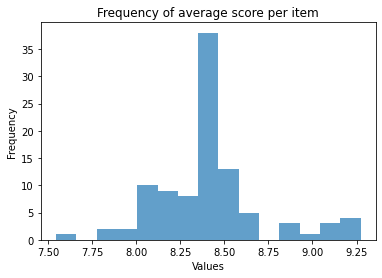

In [107]:
import matplotlib.pyplot as plt

# Create a histogram
plt.hist(average_per_item, bins='auto', alpha=0.7)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Frequency of average score per item')
plt.show()

In [113]:
averaged_data

{'obj_3': 8.202020202020202,
 'obj_8': 9.070707070707071,
 'obj_7': 8.252525252525253,
 'obj_6': 8.141414141414142,
 'obj_2': 9.141414141414142,
 'obj_10': 8.141414141414142,
 'obj_9': 7.757575757575758,
 'obj_1': 8.242424242424242,
 'obj_5': 7.787878787878788,
 'obj_11': 9.0,
 'obj_4': 8.747474747474747}

{'obj_3': 8.202020202020202, 'obj_8': 9.070707070707071, 'obj_7': 8.252525252525253, 'obj_6': 8.141414141414142, 'obj_2': 9.141414141414142, 'obj_10': 8.141414141414142, 'obj_9': 7.757575757575758, 'obj_1': 8.242424242424242, 'obj_5': 7.787878787878788, 'obj_11': 9.0, 'obj_4': 8.747474747474747}


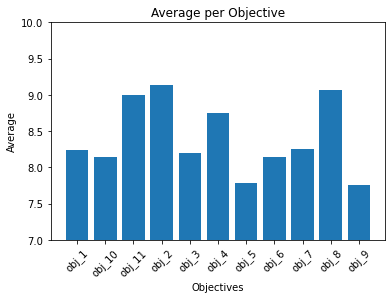

In [116]:
# Calculate the average per scores_per_objective
data = scores_per_objective
averaged_data = {key: sum(value) / len(value) for key, value in data.items()}

print(averaged_data)


sorted_data = {k: v for k, v in sorted(averaged_data.items())}

# Extract the keys (objectives) and values (averages) from the sorted dictionary
keys = sorted_data.keys()
values = sorted_data.values()

# Create a bar plot
plt.bar(keys, values)
plt.xlabel('Objectives')
plt.ylabel('Average')
plt.ylim(7,10)
plt.title('Average per Objective')
plt.xticks(rotation=45)
plt.show()

In [138]:
from scipy.stats import ttest_ind
import statistics

# Example lists of scores and indicators
scores = average_per_item
indicators = item_correct

# Separate scores based on indicators
scores_true = [score for score, indicator in zip(scores, indicators) if indicator]
scores_false = [score for score, indicator in zip(scores, indicators) if not indicator]

# Perform t-test
t_statistic, p_value = ttest_ind(scores_true, scores_false)

# Print the t-statistic and p-value
# print("T-Statistic:", t_statistic)
# print("P-Value:", p_value)

print("scores true:", statistics.mean(scores_true))
print("scores false:", statistics.mean(scores_false))

scores true: 8.415360501567399
scores false: 8.39689578713969


In [128]:
from collections import Counter

# Example list of values

# Calculate the frequencies of values
frequency = Counter(item_correct)

# Print the frequencies
for value, count in frequency.items():
    print(f"{value}: {count}")


True: 58
False: 37
None: 5


## Template 14

In [140]:
#for template 14
med_zhou_14 = Collection.from_json("med_qa_zhou_eval.json")
absolute_path = "/Users/robertpraas/Desktop/ThoughtSource/notebooks/reflection_messages/input_system/system_template_14_eval.yaml"
system_evaluate(med_zhou_14,'gpt-3.5-turbo',absolute_path)
med_zhou.dump("med_qa_template_14") 
scores_per_item, scores_per_objective, df = process_new_data(med_zhou,idx_cot=1)

Generating med_qa...


  0%|          | 0/100 [00:00<?, ?ex/s]

(API-)Error in item 1: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 6bdfea77d053684ddb43890188cc3c7b in your message.)
Retrying with additional time of 10 seconds.
(API-)Error in item 11: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Fri, 26 May 2023 14:07:14 GMT', 'Content-Type': 'application/json', 'Content-Length': '84', 'Connection': 'keep-alive', 'X-Frame-Options': 'SAMEORIGIN', 'Referrer-Policy': 'same-origin', 'Cache-Control': 'private, max-age=0, no-store, no-cache, must-revalidate, post-check=0, pre-check=0', 'Expires': 'Thu, 01 Jan 1970 00:00:01 GMT', 'Server': 'cloudflare', 'CF-RAY': '7cd68d8e5ab13257-VIE', 'alt-svc': 'h3=":443"; ma=86400'}
Retrying with additional time o

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

wrong output found


In [149]:
scores_per_item, scores_per_objective, df = process_new_data(med_zhou_14,idx_cot=1)

In [150]:
df

,Average
obj_1,9.18
obj_2,9.72
obj_3,8.74
obj_4,9.46
obj_5,8.79
obj_6,9.20
obj_7,9.14
obj_8,9.60
obj_9,8.81
obj_10,9.17


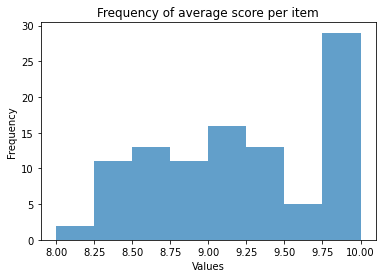

In [151]:
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]

import matplotlib.pyplot as plt

# Create a histogram
plt.hist(average_per_item, bins='auto', alpha=0.7)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Frequency of average score per item')
plt.show()

{'obj_3': 8.74, 'obj_8': 9.6, 'obj_7': 9.14, 'obj_6': 9.2, 'obj_2': 9.72, 'obj_10': 9.17, 'obj_9': 8.81, 'obj_1': 9.18, 'obj_5': 8.79, 'obj_11': 9.61, 'obj_4': 9.46}


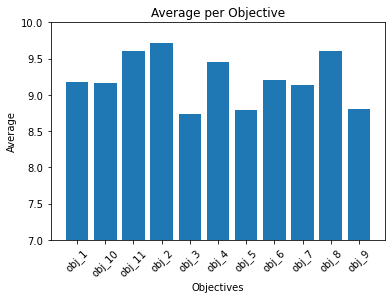

In [152]:
# Calculate the average per scores_per_objective
data = scores_per_objective
averaged_data = {key: sum(value) / len(value) for key, value in data.items()}

print(averaged_data)


sorted_data = {k: v for k, v in sorted(averaged_data.items())}

# Extract the keys (objectives) and values (averages) from the sorted dictionary
keys = sorted_data.keys()
values = sorted_data.values()

# Create a bar plot
plt.bar(keys, values)
plt.xlabel('Objectives')
plt.ylabel('Average')
plt.ylim(7,10)
plt.title('Average per Objective')
plt.xticks(rotation=45)
plt.show()

In [153]:
item_correct = []
for item in med_zhou['med_qa']['test']:
    item_correct.append(item['generated_cot'][0]['answers'][0]['correct_answer'])


from scipy.stats import ttest_ind
import statistics

# Example lists of scores and indicators
scores = average_per_item
indicators = item_correct

# Separate scores based on indicators
scores_true = [score for score, indicator in zip(scores, indicators) if indicator]
scores_false = [score for score, indicator in zip(scores, indicators) if not indicator]

# Perform t-test
t_statistic, p_value = ttest_ind(scores_true, scores_false)

# Print the t-statistic and p-value
# print("T-Statistic:", t_statistic)
# print("P-Value:", p_value)

print("scores true:", statistics.mean(scores_true))
print("scores false:", statistics.mean(scores_false))

scores true: 9.304075235109718
scores false: 9.103896103896103


## Next: GPT-4

In [10]:
import copy
med_qa = Collection.from_json("/Users/robertpraas/Desktop/ThoughtSource/notebooks/reflection_messages/med_qa_zhou_eval_gpt4.json")
med_qa_correct = copy.deepcopy(med_qa)
med_qa_false = copy.deepcopy(med_qa)
med_qa_correct.select_generated_cots(answer=True)
med_qa_correct = med_qa_correct.filter(lambda x: len(x["generated_cot"])==1)

med_qa_false.select_generated_cots(answer=False)
med_qa_false = med_qa_false.filter(lambda x: len(x["generated_cot"])==1)

In [11]:
med_qa_correct


| Name   | Train   | Valid   |   Test |
|--------|---------|---------|--------|
| med_qa | -       | -       |     81 |

Not loaded: ['aqua', 'asdiv', 'commonsense_qa', 'entailment_bank', 'gsm8k', 'mawps', 'med_qa_open', 'medmc_qa', '_init_', 'mmlu_clinical_knowledge', 'mmlu_college_biology', 'mmlu_college_medicine', 'mmlu_medical_genetics', 'mmlu_professional_medicine', '_init_', 'mmlu_anatomy', 'open_book_qa', 'pubmed_qa', 'qed', 'strategy_qa', 'svamp', 'worldtree']

In [15]:
med_qa_correct = med_qa_correct.select(split="test", number_samples=19, random_samples=True, seed=0)
med_qa_correct.dump("medqa_correct_gpt_4_sample_of_19")
med_qa_correct

| Name   | Train   | Valid   |   Test |
|--------|---------|---------|--------|
| med_qa | -       | -       |     19 |

Not loaded: ['aqua', 'asdiv', 'commonsense_qa', 'entailment_bank', 'gsm8k', 'mawps', 'med_qa_open', 'medmc_qa', '_init_', 'mmlu_clinical_knowledge', 'mmlu_college_biology', 'mmlu_college_medicine', 'mmlu_medical_genetics', 'mmlu_professional_medicine', '_init_', 'mmlu_anatomy', 'open_book_qa', 'pubmed_qa', 'qed', 'strategy_qa', 'svamp', 'worldtree']

In [12]:
med_qa_false

| Name   | Train   | Valid   |   Test |
|--------|---------|---------|--------|
| med_qa | -       | -       |     19 |

Not loaded: ['aqua', 'asdiv', 'commonsense_qa', 'entailment_bank', 'gsm8k', 'mawps', 'med_qa_open', 'medmc_qa', '_init_', 'mmlu_clinical_knowledge', 'mmlu_college_biology', 'mmlu_college_medicine', 'mmlu_medical_genetics', 'mmlu_professional_medicine', '_init_', 'mmlu_anatomy', 'open_book_qa', 'pubmed_qa', 'qed', 'strategy_qa', 'svamp', 'worldtree']

In [16]:
medqa_total = copy.deepcopy(med_qa_false)

In [19]:
medqa_total = medqa_total.merge(med_qa_correct)

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

In [21]:
medqa_total.evaluate()

  0%|          | 0/38 [00:00<?, ?ex/s]

{'med_qa': {'test': {'accuracy': {'gpt-4': {'None_zhou-01_kojima-A-E': 0.5}}}}}

In [22]:
absolute_path = "/Users/robertpraas/Desktop/ThoughtSource/notebooks/reflection_messages/input_system/system_template_14_eval.yaml"
system_evaluate(medqa_total,'gpt-4',absolute_path)
medqa_total.dump("med_qa_gpt_4_template_14") 
scores_per_item, scores_per_objective, df = process_new_data(medqa_total,idx_cot=1)


Generating med_qa...


  0%|          | 0/38 [00:00<?, ?ex/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

In [23]:
df

,Average
obj_1,10.000000
obj_2,9.710526
obj_3,9.973684
obj_4,9.736842
obj_5,9.947368
obj_6,9.710526
obj_7,8.710526
obj_8,10.000000
obj_9,9.131579
obj_10,9.973684


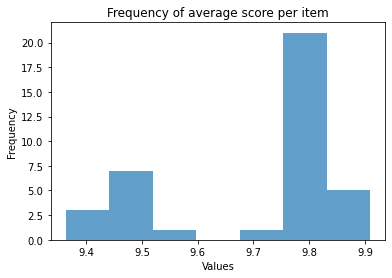

In [24]:
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]

import matplotlib.pyplot as plt

# Create a histogram
plt.hist(average_per_item, bins='auto', alpha=0.7)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Frequency of average score per item')
plt.show()

{'obj_6': 9.710526315789474, 'obj_3': 9.973684210526315, 'obj_9': 9.131578947368421, 'obj_4': 9.736842105263158, 'obj_8': 10.0, 'obj_5': 9.947368421052632, 'obj_1': 10.0, 'obj_2': 9.710526315789474, 'obj_11': 10.0, 'obj_7': 8.710526315789474, 'obj_10': 9.973684210526315}


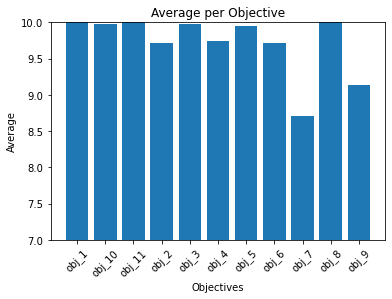

In [25]:
# Calculate the average per scores_per_objective
data = scores_per_objective
averaged_data = {key: sum(value) / len(value) for key, value in data.items()}

print(averaged_data)


sorted_data = {k: v for k, v in sorted(averaged_data.items())}

# Extract the keys (objectives) and values (averages) from the sorted dictionary
keys = sorted_data.keys()
values = sorted_data.values()

# Create a bar plot
plt.bar(keys, values)
plt.xlabel('Objectives')
plt.ylabel('Average')
plt.ylim(7,10)
plt.title('Average per Objective')
plt.xticks(rotation=45)
plt.show()

In [28]:
item_correct = []
for item in medqa_total['med_qa']['test']:
    item_correct.append(item['generated_cot'][0]['answers'][0]['correct_answer'])


from scipy.stats import ttest_ind
import statistics

# Example lists of scores and indicators
scores = average_per_item
indicators = item_correct

# Separate scores based on indicators
scores_true = [score for score, indicator in zip(scores, indicators) if indicator]
scores_false = [score for score, indicator in zip(scores, indicators) if not indicator]

# Perform t-test
t_statistic, p_value = ttest_ind(scores_true, scores_false)

# Print the t-statistic and p-value
# print("T-Statistic:", t_statistic)
# print("P-Value:", p_value)

print("scores true:", statistics.mean(scores_true))
print("scores false:", statistics.mean(scores_false))

scores true: 9.794258373205741
scores false: 9.641148325358852


In [29]:
p_value

0.009352153218818883

In [30]:
medqa_total = med_qa_false.merge(med_qa_correct)
medqa_total

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

| Name   | Train   | Valid   |   Test |
|--------|---------|---------|--------|
| med_qa | -       | -       |     38 |

Not loaded: ['aqua', 'asdiv', 'commonsense_qa', 'entailment_bank', 'gsm8k', 'mawps', 'med_qa_open', 'medmc_qa', '_init_', 'mmlu_clinical_knowledge', 'mmlu_college_biology', 'mmlu_college_medicine', 'mmlu_medical_genetics', 'mmlu_professional_medicine', '_init_', 'mmlu_anatomy', 'open_book_qa', 'pubmed_qa', 'qed', 'strategy_qa', 'svamp', 'worldtree']

In [31]:
absolute_path = "/Users/robertpraas/Desktop/ThoughtSource/notebooks/reflection_messages/input_system/system_template_12_eval.yaml"
system_evaluate(medqa_total,'gpt-4',absolute_path)
medqa_total.dump("med_qa_gpt_4_template_12") 
scores_per_item, scores_per_objective, df = process_new_data(medqa_total,idx_cot=1)


Generating med_qa...


  0%|          | 0/38 [00:00<?, ?ex/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

In [32]:
df


,Average
obj_1,10.000000
obj_2,9.447368
obj_3,10.000000
obj_4,9.394737
obj_5,9.789474
obj_6,9.447368
obj_7,8.368421
obj_8,9.973684
obj_9,8.868421
obj_10,9.842105


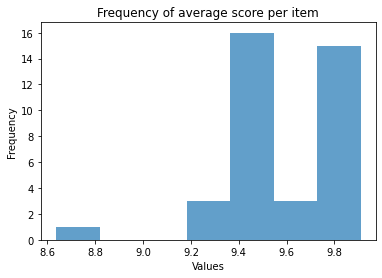

In [33]:
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]

import matplotlib.pyplot as plt

# Create a histogram
plt.hist(average_per_item, bins='auto', alpha=0.7)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Frequency of average score per item')
plt.show()


{'obj_6': 9.447368421052632, 'obj_3': 10.0, 'obj_9': 8.868421052631579, 'obj_4': 9.394736842105264, 'obj_8': 9.973684210526315, 'obj_5': 9.789473684210526, 'obj_1': 10.0, 'obj_2': 9.447368421052632, 'obj_11': 10.0, 'obj_7': 8.368421052631579, 'obj_10': 9.842105263157896}


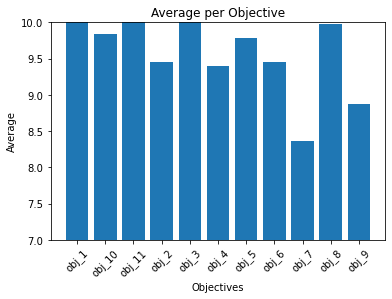

In [34]:
# Calculate the average per scores_per_objective
data = scores_per_objective
averaged_data = {key: sum(value) / len(value) for key, value in data.items()}

print(averaged_data)


sorted_data = {k: v for k, v in sorted(averaged_data.items())}

# Extract the keys (objectives) and values (averages) from the sorted dictionary
keys = sorted_data.keys()
values = sorted_data.values()

# Create a bar plot
plt.bar(keys, values)
plt.xlabel('Objectives')
plt.ylabel('Average')
plt.ylim(7,10)
plt.title('Average per Objective')
plt.xticks(rotation=45)
plt.show()


In [35]:
item_correct = []
for item in medqa_total['med_qa']['test']:
    item_correct.append(item['generated_cot'][0]['answers'][0]['correct_answer'])


from scipy.stats import ttest_ind
import statistics

# Example lists of scores and indicators
scores = average_per_item
indicators = item_correct

# Separate scores based on indicators
scores_true = [score for score, indicator in zip(scores, indicators) if indicator]
scores_false = [score for score, indicator in zip(scores, indicators) if not indicator]

# Perform t-test
t_statistic, p_value = ttest_ind(scores_true, scores_false)

# Print the t-statistic and p-value
# print("T-Statistic:", t_statistic)
# print("P-Value:", p_value)

print("scores true:", statistics.mean(scores_true))
print("scores false:", statistics.mean(scores_false))
p_value

scores true: 9.68421052631579
scores false: 9.430622009569378


0.0033949304251114903

In [ ]:
"""
For every objective, write a short judgment and rate the value of the response for all of the objectives (score between 1-10). Be critical: a higher variation in rating scores can lead to more insight.

Make sure to only output ratings of the objections. Format your response into YAML following this schema:

obj_1: 
- <Short explanation of judgment>
- [1-10 rating]
obj_2: 
- <Short explanation of judgment>
- [1-10 rating]
...
"""

## Openbook, Medmc for gpt-3

In [36]:
ob_zhou_12 = Collection.from_json("openbook_zhou_eval_chatgpt.json")
absolute_path = "/Users/robertpraas/Desktop/ThoughtSource/notebooks/reflection_messages/input_system/system_template_12_eval.yaml"
system_evaluate(ob_zhou_12,'gpt-3.5-turbo',absolute_path)
ob_zhou_12.dump("ob_template_12_chatgpt")



Generating open_book_qa...


  0%|          | 0/100 [00:00<?, ?ex/s]

(API-)Error in item 12: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Sat, 27 May 2023 15:13:56 GMT', 'Content-Type': 'application/json', 'Content-Length': '84', 'Connection': 'keep-alive', 'X-Frame-Options': 'SAMEORIGIN', 'Referrer-Policy': 'same-origin', 'Cache-Control': 'private, max-age=0, no-store, no-cache, must-revalidate, post-check=0, pre-check=0', 'Expires': 'Thu, 01 Jan 1970 00:00:01 GMT', 'Server': 'cloudflare', 'CF-RAY': '7cdf2cbb18a2c2f2-VIE', 'alt-svc': 'h3=":443"; ma=86400'}
Retrying with additional time of 10 seconds.
(API-)Error in item 37: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Sat, 27 May 2023 15:26:23 GMT', 'Content-Type': 'application/json', 'Co

NameError: name 'med_zhou' is not defined

In [25]:
ob_zhou_12 = Collection.from_json("ob_template_12_chatgpt")

In [26]:
scores_per_item, scores_per_objective, df = process_new_data(ob_zhou_12,idx_cot=1,dataset='open_book_qa',split='test')

wrong output found
wrong output found
wrong output found
wrong output found
wrong output found
obj_11 [9, 9, 9, 9, 10, 10, 10, 10, 9, 9, 10, 9, 10, 8, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 8, 9, 10, 9, 10, 9, 9, 9, 10, 10, 9, 9, 9, 9, 9, 10, 9, 10, 9, 10, 9, 10, 9, 9, 9, 9, 10, 9, 9, 9, 10, 9, 9, 9, 9, 10, 9, 10, 10, 10, 10, 9, 9, 10, 9, 9, 10, 8, 10, 10, 10, 9, 9, 10, 10, 9, 10, 10, 10, 10, 9, 9, 10, 10, 9, 10, 9, 10]
obj_6 [8, 9, 8, 8, 10, 9, 9, 9, 8, 8, 9, 7, 9, 7, 7, 8, 8, 7, 8, 8, 8, 8, 9, 10, 9, 10, 8, 7, 8, 8, 8, 10, 9, 8, 8, 8, 9, 9, 8, 8, 8, 9, 10, 8, 10, 8, 10, 8, 9, 8, 8, 8, 8, 9, 8, 8, 8, 9, 8, 9, 8, 8, 9, 8, 9, 9, 9, 9, 8, 8, 9, 8, 8, 9, 7, 9, 9, 9, 8, 8, 9, 10, 8, 9, 9, 9, 9, 8, 8, 9, 10, 8, 10, 8, 9]
Overall score [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, No

TypeError: unsupported operand type(s) for +: 'int' and 'NoneType'

In [ ]:
# to be ran
#for template 14
from cot import Collection
ob_zhou_14 = Collection.from_json("openbook_zhou_eval_chatgpt.json")
absolute_path = "/Users/robertpraas/Desktop/ThoughtSource/notebooks/reflection_messages/input_system/system_template_14_eval.yaml"
system_evaluate(ob_zhou_14,'gpt-3.5-turbo',absolute_path)
ob_zhou_14.dump("ob_template_14_chatgpt") 


In [28]:
scores_per_item, scores_per_objective, df = process_new_data(ob_zhou_14,idx_cot=1,dataset='open_book_qa',split='test')

wrong output found
wrong output found
wrong output found
wrong output found
wrong output found
wrong output found
wrong output found
obj_11 [10, 9, 10, 10, 10, 10, 10, 10, 10, 9, 10, 9, 10, 10, 10, 10, 10, 9, 10, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1, 10, 9, 10, 10, 10, 10, 9, 10, 10, 9, 10, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 10, 10, 10, 10, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 10]
obj_6 [9, 9, 9, 10, 10, 9, 10, 9, 9, 8, 10, 8, 10, 9, 9, 9, 8, 8, 10, 9, 10, 10, 10, 10, 10, 10, 10, 9, 9, 10, 10, 10, 10, 8, 9, 10, 9, 10, 9, 10, 9, 9, 10, 9, 10, 9, 10, 10, 9, 9, 9, 9, 10, 10, 9, 10, 10, 8, 9, 10, 9, 9, 10, 10, 10, 10, 10, 9, 10, 9, 9, 10, 8, 10, 10, 9, 9, 8, 10, 10, 8, 10, 10, 10, 9, 9, 10, 9, 10, 9, 10, 8, 10]
obj_4 [10, 9, 10, 10, 10, 10, 10, 10, 10, 8, 10, 8, 10, 10, 10, 10, 8, 7, 10, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 8, 10, 10, 10, 10, 9, 10, 10, 9, 10

         Average
obj_1   9.677419
obj_2   9.956989
obj_3   8.537634
obj_4   9.666667
obj_5   9.010753
obj_6   9.397849
obj_7   9.301075
obj_8   9.827957
obj_9   8.344086
obj_10  9.258065
obj_11  9.763441
scores true: 9.269972451790634
scores false: 9.511784511784512


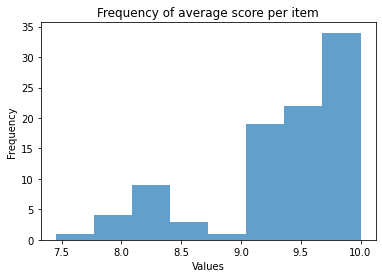

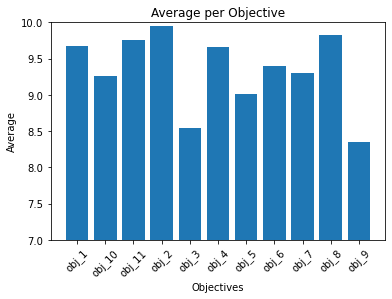

In [45]:
print(df)
avg_true_false(ob_zhou_14,'open_book_qa','test')
freq_bar_plot(scores_per_item)
avg_item_plot(scores_per_objective)

## try written feedback

In [46]:
med_zhou = Collection.from_json("med_qa_zhou_eval.json")
med_zhou = med_zhou.select(split="test", number_samples=1, random_samples=True, seed=0)


In [56]:
med_zhou

| Name   | Train   | Valid   |   Test |
|--------|---------|---------|--------|
| med_qa | -       | -       |      1 |

Not loaded: ['aqua', 'asdiv', 'commonsense_qa', 'entailment_bank', 'gsm8k', 'mawps', 'med_qa_open', 'medmc_qa', '_init_', 'mmlu_clinical_knowledge', 'mmlu_college_biology', 'mmlu_college_medicine', 'mmlu_medical_genetics', 'mmlu_professional_medicine', '_init_', 'mmlu_anatomy', 'open_book_qa', 'pubmed_qa', 'qed', 'strategy_qa', 'svamp', 'worldtree']

In [50]:
absolute_path = "./input_system/system_template_15_eval.yaml"
system_evaluate(med_zhou,'gpt-3.5-turbo',absolute_path)



Generating med_qa...


  0%|          | 0/1 [00:00<?, ?ex/s]

In [54]:
med_zhou['med_qa']['test'][0]['generated_cot'][1]['cot']

"obj_1: The response accurately interprets the question and breaks it down into relevant components, including the patient's symptoms, the findings on workup, and the answer options.\n- 10\n\nobj_2: The response considers all relevant information, including the patient's symptoms, the findings on workup, and the characteristics of each answer option. The response specifically avoids considering irrelevant information.\n- 10\n\nobj_3: The response is sensitive to the numerical information provided by the user, accurately interpreting and incorporating it into the response. The response notes the absence of germinal centers in the lymph node biopsy, which suggests a T-cell deficiency.\n- 10\n\nobj_4: The response considers all relevant reasoning strategies, including the characteristics of each answer option and the patient's symptoms and findings on workup. The response selects the most appropriate reasoning strategy by focusing on the T-cell deficiency suggested by the lymph node biops

In [55]:
"obj_1: The response accurately interprets the question and breaks it down into relevant components, including the patient's symptoms, the findings on workup, and the answer options.\n- 10\n\nobj_2: The response considers all relevant information, including the patient's symptoms, the findings on workup, and the characteristics of each answer option. The response specifically avoids considering irrelevant information.\n- 10\n\nobj_3: The response is sensitive to the numerical information provided by the user, accurately interpreting and incorporating it into the response. The response notes the absence of germinal centers in the lymph node biopsy, which suggests a T-cell deficiency.\n- 10\n\nobj_4: The response considers all relevant reasoning strategies, including the characteristics of each answer option and the patient's symptoms and findings on workup. The response selects the most appropriate reasoning strategy by focusing on the T-cell deficiency suggested by the lymph node biopsy.\n- 10\n\nobj_5: The reasoning in the response is structured through a clear and concise analysis of each answer option, with a focus on the T-cell deficiency suggested by the lymph node biopsy. The response is structured at an appropriate level of detail.\n- 10\n\nobj_6: The response gives appropriate priorities to different considerations based"


"obj_1: The response accurately interprets the question and breaks it down into relevant components, including the patient's symptoms, the findings on workup, and the answer options.\n- 10\n\nobj_2: The response considers all relevant information, including the patient's symptoms, the findings on workup, and the characteristics of each answer option. The response specifically avoids considering irrelevant information.\n- 10\n\nobj_3: The response is sensitive to the numerical information provided by the user, accurately interpreting and incorporating it into the response. The response notes the absence of germinal centers in the lymph node biopsy, which suggests a T-cell deficiency.\n- 10\n\nobj_4: The response considers all relevant reasoning strategies, including the characteristics of each answer option and the patient's symptoms and findings on workup. The response selects the most appropriate reasoning strategy by focusing on the T-cell deficiency suggested by the lymph node biops

In [57]:
absolute_path = "./input_system/system_template_15_eval.yaml"
system_evaluate(med_zhou,'gpt-4',absolute_path)

Generating med_qa...


  0%|          | 0/1 [00:00<?, ?ex/s]

In [59]:
med_zhou['med_qa']['test'][0]['generated_cot'][2]['cot']

'obj_1: \n- Accurately interprets the question and breaks it down\n- 10\nobj_2: \n- Considers all relevant information and avoids irrelevant information\n- 10\nobj_3: \n- N/A (no numerical information provided)\n- N/A\nobj_4: \n- Considers all relevant reasoning strategies and selects the most appropriate one\n- 10\nobj_5: \n- Reasoning is structured through reasoning steps and sub-questions\n- 10\nobj_6: \n- Gives appropriate priorities to different considerations based on their relevance and importance\n- 10\nobj_7: \n- Lists and considers all relevant underlying assumptions\n- 10\nobj_8: \n- Response is plausible, logically valid, sound, consistent, and coherent\n- 10\nobj_9: \n- Statements are supported by references to evidence (symptoms, gene associations, and biopsy findings)\n- 10\nobj_10: \n- Contains accurate, relevant, and up-to-date information\n- 10\nobj_11: \n- Provides a single final answer based on the reasoning and verifies that it corresponds to one of the answer opti

In [64]:
absolute_path = "./input_system/system_template_16_eval.yaml"
system_evaluate(med_zhou,'gpt-3.5-turbo',absolute_path)

Generating med_qa...


  0%|          | 0/1 [00:00<?, ?ex/s]

In [65]:
med_zhou['med_qa']['test'][0]['generated_cot'][5]['cot']

"obj_1: The response accurately interprets the question and breaks it down into relevant components, including the patient's symptoms, diagnostic findings, and potential causes.\n- 10\n\nobj_2: The response considers all relevant information, including the patient's symptoms, diagnostic findings, and potential causes, while avoiding irrelevant information.\n- 10\n\nobj_3: The response is sensitive to the numerical information provided by the user, accurately interpreting and incorporating it into the response by considering the absence of germinal centers in the lymph node biopsy as indicative of a T-cell deficiency.\n- 9\n\nobj_4: The response considers all relevant reasoning strategies, including the use of the patient's symptoms and diagnostic findings to narrow down potential causes, and selects the most appropriate reasoning strategy by focusing on the absence of germinal centers in the lymph node biopsy as indicative of a T-cell deficiency.\n- 9\n\nobj_5: The reasoning in the res

In [66]:
absolute_path = "./input_system/system_template_16_eval.yaml"
system_evaluate(med_zhou,'gpt-4',absolute_path)

Generating med_qa...


  0%|          | 0/1 [00:00<?, ?ex/s]

In [69]:
med_zhou['med_qa']['test'][0]['generated_cot'][6]['cot']

'obj_1: \n- The response interprets the question accurately and breaks it down by considering the symptoms and the possible causes.\n- 10\nobj_2: \n- The response considers all relevant information from the question and answer options, and avoids considering irrelevant information.\n- 10\nobj_3: \n- The response does not involve numerical information, so this objective is not applicable.\n- N/A\nobj_4: \n- The response considers all relevant reasoning strategies by evaluating each answer option and selecting the most appropriate one based on the symptoms and findings.\n- 10\nobj_5: \n- The reasoning in the response is structured through reasoning steps, evaluating each answer option and providing explanations for why they are less likely.\n- 10\nobj_6: \n- The response gives appropriate priorities to different considerations based on their relevance and importance, focusing on the symptoms and findings.\n- 10\nobj_7: \n- The response lists and considers the relevant underlying assumpti

In [ ]:
#does not seem to work: tweak prompt

## GPT-4 assess GPT-3.5

In [76]:
data = Collection.from_json("med_qa_zhou_eval.json")
data = data.select(split="test", number_samples=5, random_samples=True, seed=0)
data


| Name   | Train   | Valid   |   Test |
|--------|---------|---------|--------|
| med_qa | -       | -       |      5 |

Not loaded: ['aqua', 'asdiv', 'commonsense_qa', 'entailment_bank', 'gsm8k', 'mawps', 'med_qa_open', 'medmc_qa', '_init_', 'mmlu_clinical_knowledge', 'mmlu_college_biology', 'mmlu_college_medicine', 'mmlu_medical_genetics', 'mmlu_professional_medicine', '_init_', 'mmlu_anatomy', 'open_book_qa', 'pubmed_qa', 'qed', 'strategy_qa', 'svamp', 'worldtree']

In [77]:
absolute_path = "./input_system/system_template_14_eval.yaml"
system_evaluate(data,'gpt-4',absolute_path)
# medqa_total.dump("med_qa_gpt_4_template_12") 


Generating med_qa...


  0%|          | 0/5 [00:00<?, ?ex/s]

TypeError: process_new_data() missing 2 required positional arguments: 'dataset' and 'split'

In [79]:
scores_per_item, scores_per_objective, df = process_new_data(data,idx_cot=1,dataset='med_qa',split='test')

obj_11 [10, 6, 10, 10, 10]
obj_6 [10, 8, 9, 8, 10]
obj_4 [10, 8, 9, 8, 10]
obj_9 [9, 7, 9, 7, 9]
obj_2 [10, 8, 9, 8, 10]
obj_3 [10, 8, 10, 10, 10]
obj_10 [10, 9, 10, 9, 10]
obj_5 [10, 9, 9, 9, 10]
obj_8 [10, 8, 10, 9, 10]
obj_7 [9, 7, 8, 7, 9]
obj_1 [10, 9, 10, 9, 10]


In [80]:
data.dump("test_gpt4_on_3_14")

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

In [74]:
absolute_path = "./input_system/system_template_12_eval.yaml"
system_evaluate(data,'gpt-4',absolute_path)
# medqa_total.dump("med_qa_gpt_4_template_12") 
scores_per_item, scores_per_objective, df = process_new_data(medqa_total,idx_cot=1)

Generating med_qa...


  0%|          | 0/1 [00:00<?, ?ex/s]

In [75]:
data['med_qa']['test'][0]['generated_cot'][2]['cot']

'obj_1: 10\nobj_2: 9\nobj_3: 10\nobj_4: 9\nobj_5: 9\nobj_6: 9\nobj_7: 8\nobj_8: 9\nobj_9: 9\nobj_10: 9\nobj_11: 10'

In [ ]:
absolute_path = "./input_system/system_template_16_eval.yaml"
system_evaluate(med_zhou,'gpt-3.5-turbo',absolute_path)

## 3.5 corrects Cohere

In [22]:
from cot import Collection
med_co = Collection.from_json("med_qa_zhou_cohere.json")
#med_co = med_co.select(split="test", number_samples=1, random_samples=True, seed=0)


In [ ]:
from cot import Collection
med_co = Collection.from_json("med_qa_zhou_cohere.json")
#med_co = med_co.select(split="test", number_samples=1, random_samples=True, seed=0)

In [23]:
med_co

| Name   | Train   | Valid   |   Test |
|--------|---------|---------|--------|
| med_qa | -       | -       |    100 |

Not loaded: ['aqua', 'asdiv', 'commonsense_qa', 'entailment_bank', 'gsm8k', 'mawps', 'med_qa_open', 'medmc_qa', '_init_', 'mmlu_clinical_knowledge', 'mmlu_college_biology', 'mmlu_college_medicine', 'mmlu_medical_genetics', 'mmlu_professional_medicine', '_init_', 'mmlu_anatomy', 'open_book_qa', 'pubmed_qa', 'qed', 'strategy_qa', 'svamp', 'worldtree']

In [24]:
absolute_path = "./input_system/system_template_14_eval.yaml"
system_evaluate(med_co,'gpt-3.5-turbo',absolute_path)
med_co.dump("chatgpt_judges_cohere")

Generating med_qa...


  0%|          | 0/100 [00:00<?, ?ex/s]

(API-)Error in item 30: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 2b797b87820009fba581ccdd214e8a7c in your message.)
Retrying with additional time of 10 seconds.


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

In [26]:
scores_per_item, scores_per_objective, df = process_new_data(med_co,idx_cot=1,dataset='med_qa',split='test')

wrong output found
wrong output found
wrong output found
obj_4 [10, 9, 8, 10, 10, 10, 10, 9, 10, 10, 10, 9, 10, 8, 8, 8, 10, 7, 10, 10, 9, 8, 10, 10, 4, 10, 7, 8, 9, 10, 10, 10, 7, 8, 8, 6, 8, 4, 8, 6, 8, 9, 6, 8, 10, 10, 8, 10, 10, 10, 5, 8, 10, 9, 10, 9, 10, 8, 8, 10, 10, 8, 10, 8, 10, 10, 7, 10, 6, 8, 10, 10, 10, 8, 10, 8, 10, 6, 9, 8, 10, 8, 10, 10, 9, 10, 10, 10, 10, 8, 10, 10, 10, 10, 10, 10, 7]
obj_8 [10, 9, 9, 10, 10, 10, 10, 9, 10, 10, 10, 9, 10, 9, 9, 9, 10, 8, 10, 10, 9, 9, 10, 10, 6, 10, 8, 9, 10, 10, 10, 10, 7, 9, 9, 8, 8, 4, 8, 8, 8, 9, 8, 9, 10, 10, 9, 10, 10, 10, 6, 9, 10, 9, 10, 9, 10, 9, 9, 10, 10, 9, 10, 9, 10, 10, 8, 10, 8, 8, 10, 10, 10, 9, 10, 9, 10, 8, 9, 8, 10, 9, 10, 10, 9, 10, 10, 10, 10, 8, 10, 10, 10, 10, 10, 10, 8]
obj_2 [10, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 9, 10, 9, 9, 9, 10, 9, 10, 10, 9, 9, 10, 10, 9, 10, 9, 9, 10, 10, 10, 10, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 9, 10, 10, 10, 9, 10, 10, 9, 10, 9, 10, 10, 9, 10, 10, 9, 10, 9, 10, 10, 9, 10,

         Average
obj_1   9.030928
obj_2   9.556701
obj_3   8.061856
obj_4   8.865979
obj_5   7.948454
obj_6   8.690722
obj_7   8.628866
obj_8   9.237113
obj_9   7.927835
obj_10  8.680412
obj_11  9.298969
scores true: 8.733333333333333
scores false: 8.71506105834464


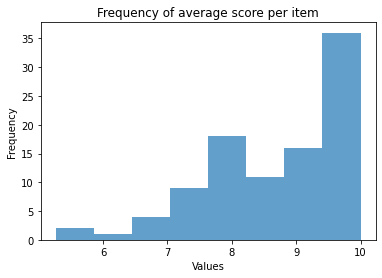

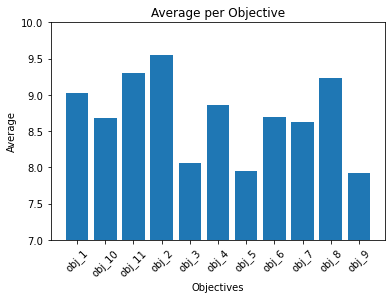

In [30]:
# This way ChatGPT does not correct cohere in anyway, need to ask it to dig deeper/more concrete

print(df)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]
avg_true_false(med_co,average_per_item,'med_qa','test')
freq_bar_plot(scores_per_item)
avg_item_plot(scores_per_objective)

In [39]:
from cot import Collection
med_co = Collection.from_json("med_qa_zhou_cohere.json")
# med_co = med_co.select(split="test", number_samples=5, random_samples=True, seed=0)


In [32]:
absolute_path = "./input_system/system_template_16_improve.yaml"
system_evaluate(med_co,'gpt-3.5-turbo',absolute_path)


Generating med_qa...


  0%|          | 0/5 [00:00<?, ?ex/s]

In [33]:
med_co.dump("correction_test")

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

In [40]:
med_co.evaluate()

  0%|          | 0/100 [00:00<?, ?ex/s]

{'med_qa': {'test': {'accuracy': {'command-xlarge-nightly': {'None_zhou-01_kojima-A-E': 0.32}}}}}

In [36]:
med_co.select_generated_cots(answer=False)
med_co_false = med_co.filter(lambda x: len(x["generated_cot"])==1)

In [37]:
med_co_false

| Name   | Train   | Valid   |   Test |
|--------|---------|---------|--------|
| med_qa | -       | -       |     68 |

Not loaded: ['aqua', 'asdiv', 'commonsense_qa', 'entailment_bank', 'gsm8k', 'mawps', 'med_qa_open', 'medmc_qa', '_init_', 'mmlu_clinical_knowledge', 'mmlu_college_biology', 'mmlu_college_medicine', 'mmlu_medical_genetics', 'mmlu_professional_medicine', '_init_', 'mmlu_anatomy', 'open_book_qa', 'pubmed_qa', 'qed', 'strategy_qa', 'svamp', 'worldtree']

In [41]:
absolute_path = "./input_system/system_template_16_improve.yaml"
system_evaluate(med_co,'gpt-3.5-turbo',absolute_path)

Generating med_qa...


  0%|          | 0/100 [00:00<?, ?ex/s]

(API-)Error in item 3: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID ec4033ca79513c56921a4c5a91dde67e in your message.)
Retrying with additional time of 10 seconds.
(API-)Error in item 17: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 83d987a460cff5dcda0bf041d64a3c64 in your message.)
Retrying with additional time of 10 seconds.


In [42]:
med_co.dump("full_chatgpt_cohere_correction")

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

In [43]:
absolute_path = "./input_system/system_template_16_improve.yaml"
system_evaluate(med_co,'gpt-4',absolute_path)

Generating med_qa...


  0%|          | 0/100 [00:00<?, ?ex/s]

(API-)Error in item 31: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID f7933b7535f23c4a9629ef0929a6e0ba in your message.)
Retrying with additional time of 10 seconds.
(API-)Error in item 60: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID d91af4f8bc51adbb8c70853969ebf927 in your message.)
Retrying with additional time of 10 seconds.
(API-)Error in item 94: HTTP code 502 from API (<html>
<head><title>502 Bad Gateway</title></head>
<body>
<center><h1>502 Bad Gateway</h1></center>
<hr><center>cloudflare</center>
</body>
</html>
)
Retrying with additional time of 10 seconds.


In [44]:
med_co.dump("gpt_3_4_cohere_correction")

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

In [48]:
med_co['med_qa']['test'][0]

{'id': 'med_qa_test_2',
 'ref_id': '',
 'question': 'Two weeks after undergoing an emergency cardiac catherization with stenting for unstable angina pectoris, a 61-year-old man has decreased urinary output and malaise. He has type 2 diabetes mellitus and osteoarthritis of the hips. Prior to admission, his medications were insulin and naproxen. He was also started on aspirin, clopidogrel, and metoprolol after the coronary intervention. His temperature is 38°C (100.4°F), pulse is 93/min, and blood pressure is 125/85 mm Hg. Examination shows mottled, reticulated purplish discoloration of the feet. Laboratory studies show:\nHemoglobin count 14 g/dL\nLeukocyte count 16,400/mm3\nSegmented neutrophils 56%\nEosinophils 11%\nLymphocytes 31%\nMonocytes 2%\nPlatelet count 260,000/mm3\nErythrocyte sedimentation rate 68 mm/h\nSerum\nUrea nitrogen 25 mg/dL\nCreatinine 4.2 mg/dL\nRenal biopsy shows intravascular spindle-shaped vacuoles. Which of the following is the most likely cause of this patient\

In [89]:
med_co = Collection.from_json("gpt_3_4_cohere_correction")

In [90]:
import yaml
import re
count = 0
for j,element in enumerate(med_co['med_qa']['test']):
    for i in range(1,3):
        yaml_content = element['generated_cot'][i]['cot']
        try:
        #print(yaml_content)
            yaml_data = yaml.load(yaml_content, Loader=yaml.FullLoader)
            final_answer = yaml_data['final_answer']
            cot = yaml_data['corrected_reasoning']
            element['generated_cot'][i]['cot'] = cot
            element['generated_cot'][i]['answers'][0]['answer'] = final_answer   
        except:
            try:
                yaml_content = yaml_content.replace("corrected_reasoning: \n", "corrected_reasoning: ")
                #yaml_content = re.sub(r'([^:\n]+):\n', r'\n\1: ', yaml_content)
                yaml_data = yaml.load(yaml_content, Loader=yaml.FullLoader)
                final_answer = yaml_data['final_answer']
                cot = yaml_data['corrected_reasoning']
                element['generated_cot'][i]['cot'] = cot
                element['generated_cot'][i]['answers'][0]['answer'] = final_answer
                med_co['med_qa']['test'][j] = element
            except:
                print(i)
                print("wrong output found")
                # print(yaml_content)
                count +=1
                continue
    med_co['med_qa']['test'][j] = element
print(count)
med_co.evaluate()    
        






        #     yaml_content = yaml_content.replace('\n', ' ')
        #     try:
        #         yaml_data = yaml.load(yaml_content, Loader=yaml.FullLoader)
        #         final_answer = yaml_data['final_answer']
        #         cot = yaml_data['corrected_reasoning']
        #         element['generated_cot'][i]['cot'] = cot
        #         element['generated_cot'][i]['answers'][0]['answer'] = final_answer
        #     except:
        #         print("wrong output found")
        #         print(yaml_content)
        #         count +=1
        #         continue
        #yaml_data = yaml.safe_load(yaml_content)





# import yaml

# # Assuming the YAML content is stored in a string variable called 'yaml_content'
# yaml_data = yaml.safe_load(yaml_content)

# # Extracting the final_answer
# final_answer = yaml_data['final_answer']

1
wrong output found


TypeError: 'Dataset' object does not support item assignment

In [ ]:
#this does not work - write data.map function

In [88]:
len(med_co['med_qa']['test'][99])

10

In [76]:
str = """corrected_reasoning: 
The given reasoning is correct.

final_answer: C."""
str = str.replace("corrected_reasoning: \n", "corrected_reasoning: ")
yaml_data = yaml.load(str, Loader=yaml.FullLoader)
yaml_data['final_answer']

'C.'

In [ ]:
#####

In [9]:
absolute_path = "./input_system/system_template_12_eval.yaml"
system_evaluate(med_co,'gpt-3.5-turbo',absolute_path)

Generating med_qa...


In [10]:
absolute_path = "./input_system/system_template_16_eval.yaml"
system_evaluate(med_co,'gpt-3.5-turbo',absolute_path)

Generating med_qa...
(API-)Error in item 0: HTTP code 502 from API (<html>
<head><title>502 Bad Gateway</title></head>
<body>
<center><h1>502 Bad Gateway</h1></center>
<hr><center>cloudflare</center>
</body>
</html>
)
Retrying with additional time of 10 seconds.


In [16]:
absolute_path = "./input_system/system_template_17.yaml"
system_evaluate(med_co,'gpt-3.5-turbo',absolute_path)

Generating med_qa...


In [21]:
med_co['med_qa']['test'][0]['generated_cot'][1]['cot']

'obj_1: 8\nobj_2: 10\nobj_3: 8\nobj_4: 8\nobj_5: 7\nobj_6: 8\nobj_7: 8\nobj_8: 9\nobj_9: 7\nobj_10: 8\nobj_11: 10'

In [ ]:
scores_per_item, scores_per_objective, df = process_new_data(data,idx_cot=1,dataset='med_qa',split='test')